In [1]:
from c3dReadClass import C3DData 
from walkingSubjects import subjectToTrialMap as walkingSubjectsMap
from jumpingSubjects import subjectToTrialMap as jumpingSubjectsMap
from jumpingSubjects import runningSubjectToTrialMap as runningSubjectsMap
from jumpingSubjects import otherSubjectToTrialMap

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
import numpy as np
from numpy import mean
from numpy import std

Using TensorFlow backend.


In [2]:
ALL_C3D_DIR = "./data/allc3d/subjects/"

# this is how the file paths are
def getPaddedNumberToString(subjectOrTrialNumber):
    dirName = str(subjectOrTrialNumber)
    if len(dirName) < 2:
        dirName = '0' + dirName
    return dirName

def readAllC3dFiles(subjectToTrialMap):
    
    ## to record errors
    fileNotFound = []
    
    subjectsDataArray = []
    for subjectNumber in subjectToTrialMap.keys():
        dirPath = ALL_C3D_DIR + getPaddedNumberToString(subjectNumber) + "/"
        for trialNumber in subjectToTrialMap[subjectNumber]:
            filePath = dirPath + getPaddedNumberToString(subjectNumber) + "_" + getPaddedNumberToString(trialNumber) + ".c3d"
            # print(filePath)
            try:
                c3dBinaryFile = C3DData(None, filePath)
                subjectsDataArray.append(c3dBinaryFile)
            except:
                fileNotFound.append("file not found, subjectNum: " + str(subjectNumber) + " ,trial: " + str(trialNumber) + " filePath: " + filePath )
    
    with open("errorFile.log", 'a') as f:
        for errorLine in fileNotFound:
            f.write(errorLine + '\n')

    return subjectsDataArray


In [3]:
def summarize_results(scores):
	print(scores)
	m, s = mean(scores), std(scores)
	print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))


# fit and evaluate a model
def evaluate_model(trainX, trainy, testX, testy):
	verbose, epochs, batch_size = 0, 15, 64
	n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
	model = Sequential()
	model.add(LSTM(100, input_shape=(n_timesteps,n_features)))
	model.add(Dropout(0.5))
	model.add(Dense(100, activation='relu'))
	model.add(Dense(n_outputs, activation='softmax'))
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	# fit network
	model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
	# evaluate model
	_, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
	return accuracy


# run an experiment
def run_experiment(trainX, trainY, testX, testY, repeats=10):
	# load data
	# trainX, trainy, testX, testy = load_dataset()
	# repeat experiment
	scores = list()
	for r in range(repeats):
		score = evaluate_model(trainX, trainY, testX, testY)
		score = score * 100.0
		print('>#%d: %.3f' % (r+1, score))
		scores.append(score)
	# summarize results
	summarize_results(scores)

In [4]:
print("\n")
with open("errorFile.log", 'w') as f:
    f.write("New logs" + '\n')

walkingSubjectsDataArray = readAllC3dFiles(walkingSubjectsMap)
print("walking: " + str(len(walkingSubjectsDataArray)) )
jumpingSubjectsDataArray = readAllC3dFiles(jumpingSubjectsMap)
print("jumping: " + str(len(jumpingSubjectsDataArray)) )
runningSubjectsDataArray = readAllC3dFiles(runningSubjectsMap)
print("running: " + str(len(runningSubjectsDataArray)) )
otherSubjectsDataArray = readAllC3dFiles(otherSubjectToTrialMap)
print("other activities: " + str(len(otherSubjectsDataArray)) )
allSubjectsDataArray = walkingSubjectsDataArray + jumpingSubjectsDataArray + runningSubjectsDataArray + otherSubjectsDataArray
# allSubjectsDataArray = walkingSubjectsDataArray + jumpingSubjectsDataArray
markersPerSubject = {}
allTrialsMarkerFrames = []



walking: 78
jumping: 19
running: 37
other activities: 29


In [11]:
type(allSubjectsDataArray)
type(allSubjectsDataArray[0].Data)


dict

In [12]:
totalTrialsLoaded = len(allSubjectsDataArray)
print("no of trials: " + str(totalTrialsLoaded) )


markerCount = {}
commonMarkersArray = []
commonMarkersMap = {}
minimumFrameCount = 9999

no of trials: 163


In [13]:
for trial in allSubjectsDataArray:
    thisSubjectMarkerData = trial.Data['Markers']
    markersThisTrial = thisSubjectMarkerData.keys()
    thisSubjectMarkerFrames = {}
    for markerKey in markersThisTrial:
        # print("marker is: " + markerKey + " and type is: " + str(type(markerKey)))
        thisTrialFrameCount = thisSubjectMarkerData[markerKey].shape[1]
        if(thisTrialFrameCount < minimumFrameCount):
            minimumFrameCount = thisTrialFrameCount
        try:
            strippedMarkerKey = markerKey.split(':')[1]
            thisSubjectMarkerFrames[strippedMarkerKey] = thisSubjectMarkerData[markerKey]
            # print("shape: " + str(thisSubjectMarkerData[markerKey].shape) )

            if(markerCount.get(strippedMarkerKey)==None):
                markerCount[strippedMarkerKey] = 1
            else:
                markerCount[strippedMarkerKey] += 1
                if(markerCount[strippedMarkerKey] == totalTrialsLoaded):
                    commonMarkersArray.append(strippedMarkerKey)
                    commonMarkersMap[strippedMarkerKey] = True

        except:
            # print("cannot split: " + markerKey )
            strippedMarkerKey = markerKey
#     if(np.isnan(thisSubjectMarkerFrames).any()):
#         print("there is nan")
#     print("type: " + str(type(thisSubjectMarkerFrames)))
    allTrialsMarkerFrames.append(thisSubjectMarkerFrames)


print("common markers count: " + str(len(commonMarkersArray)) )
print(commonMarkersArray)
print("minimum frames count: " + str(minimumFrameCount) )

common markers count: 41
['C7', 'CLAV', 'LANK', 'LBHD', 'LBWT', 'LELB', 'LFHD', 'LFIN', 'LFRM', 'LFWT', 'LHEE', 'LKNE', 'LMT5', 'LSHN', 'LSHO', 'LTHI', 'LTOE', 'LUPA', 'LWRA', 'LWRB', 'RANK', 'RBAC', 'RBHD', 'RBWT', 'RELB', 'RFHD', 'RFIN', 'RFRM', 'RFWT', 'RHEE', 'RKNE', 'RMT5', 'RSHN', 'RSHO', 'RTHI', 'RTOE', 'RUPA', 'RWRA', 'RWRB', 'STRN', 'T10']
minimum frames count: 127


In [14]:
allTrialData = list()

# TODO: switch back to 128 frames, some example has only 127 frames, or just use the minimum no of frames encountered so far
# [samples, 128, 123]
# iterate the array of frames

# count = 0

for trialMap in allTrialsMarkerFrames:
    # iterate the map of markerKey -> frames
    allMarkerFrames = np.zeros((127, 0))
    for markerKey in trialMap:
        if(commonMarkersMap.get(markerKey)!=None ):
#             print(trialMap[markerKey].shape)
            perMarkerFrames = trialMap[markerKey].transpose()[0:127, 0:3]
            # print("shape: " + str(perMarkerFrames.shape) )
            allMarkerFrames = np.concatenate((allMarkerFrames, perMarkerFrames), 1)
#         else:
#             print("marker key not found: or is nan " )
#             count += 1
#     print(allMarkerFrames.shape)
    allTrialData.append(allMarkerFrames)
# print('count is: ' + str(count))
allTrialData = np.asarray(allTrialData)
print("all trial data " + str(allTrialData.shape))

all trial data (163, 127, 123)


### remove all nans
set them to zero

TODO: find a better way of doing this

In [46]:
import math

allTrialData.shape

for i in range(allTrialData.shape[0]):
    for j in range(allTrialData.shape[1]):
        for k in range(allTrialData.shape[2]):
            if(math.isnan(allTrialData[i][j][k]) ):
                allTrialData[i][j][k] = 0


In [48]:
np.argwhere( np.isnan(allTrialData))
np.isnan(allTrialData).any()

False

In [49]:
walkingSubjectsCount = len(walkingSubjectsDataArray)
otherSubjectsCount = totalTrialsLoaded - walkingSubjectsCount
allOutputLabels = [0] * walkingSubjectsCount + [1] * otherSubjectsCount
print("output shape: " + str(len(allOutputLabels)) )
# 0 - walking, 1 - not walking

output shape: 163


In [50]:
def performTrainTestSplit(allTrialData, allOutputLabels, walkingSubjectsCount, otherSubjectsCount):
    ## do train test split

    print("walking sub: " + str(walkingSubjectsCount))
    print("other sub: " + str(otherSubjectsCount))

    trainWalkCount = int(0.7*walkingSubjectsCount)
    trainOtherCount = int(0.7*otherSubjectsCount)


    print("walking train: " + str(trainWalkCount))
    print("other train: " + str(trainOtherCount))

    trainX = np.concatenate( (allTrialData[0:trainWalkCount], allTrialData[walkingSubjectsCount: walkingSubjectsCount+trainOtherCount]), axis=0 )
    testX = np.concatenate( (allTrialData[trainWalkCount: (walkingSubjectsCount-trainWalkCount)], allTrialData[walkingSubjectsCount: walkingSubjectsCount+(otherSubjectsCount-trainOtherCount) ]), axis=0 )

    trainY = np.concatenate( (allOutputLabels[0:trainWalkCount], allOutputLabels[walkingSubjectsCount: walkingSubjectsCount+trainOtherCount]), axis=0)
    testY = np.concatenate( (allOutputLabels[trainWalkCount: (walkingSubjectsCount-trainWalkCount)], allOutputLabels[walkingSubjectsCount: walkingSubjectsCount+(otherSubjectsCount-trainOtherCount)]), axis=0 )

    return trainX, trainY, testX, testY

In [83]:
from sklearn.model_selection import train_test_split
trainX, testX, trainY, testY = train_test_split(allTrialData, allOutputLabels, test_size=0.25, random_state=42)

In [79]:
trainX, trainY, testX, testY = performTrainTestSplit(allTrialData, allOutputLabels, walkingSubjectsCount, otherSubjectsCount)

walking sub: 78
other sub: 85
walking train: 54
other train: 59


In [84]:
testX.shape
trainX.shape
trainY.shape
testY.shape
testY
# allOutputLabels

AttributeError: 'list' object has no attribute 'shape'

In [53]:
testYTrans = keras.utils.to_categorical(testY)
trainYTrans = keras.utils.to_categorical(trainY)
trainYTrans.shape
trainYTrans

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.

In [54]:
run_experiment(trainX, trainYTrans, testX, testYTrans)

>#1: 73.077
>#2: 50.000
>#3: 46.154
>#4: 30.769
>#5: 50.000
>#6: 50.000
>#7: 50.000
>#8: 50.000
>#9: 50.000
>#10: 53.846
[73.07692170143127, 50.0, 46.15384638309479, 30.769231915473938, 50.0, 50.0, 50.0, 50.0, 50.0, 53.84615659713745]
Accuracy: 50.385% (+/-9.646)


In [55]:
trainYTrans.shape[1]

2

In [56]:
trainX.shape

(113, 127, 123)

In [57]:
from keras.callbacks import History 
history = History()

In [58]:
np.isnan(trainX).any()
whereNan = np.argwhere(np.isnan(trainX))

# trainX.shape
unique = np.unique( whereNan[:, 0] )
unique
# trainX[3][0][87]


array([], dtype=int64)

In [59]:
np.isnan(testX).any()
whereNan = np.argwhere(np.isnan(testX))

whereNan
whereNan[:, 0]
# trainX.shape
# unique = np.unique( whereNan[:, 0] )
# unique

array([], dtype=int64)

In [134]:


verbose, epochs, batch_size = 0, 50, 4
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], 1#trainY.shape[0]
model = Sequential()
model.add(LSTM(100, input_shape=(n_timesteps,n_features)))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit network
history = model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=verbose)

In [135]:
print(history.history)

{'loss': [0.6353797267694943, 0.5244435350425908, 0.4600062905276408, 0.48923283913096444, 0.4767435662081984, 0.4409292389134892, 0.4142280919630019, 0.4274686533408087, 0.43868314969490785, 0.3977677972346056, 0.3946518590215777, 0.36462894326350725, 0.37755814127501897, 0.3890041224047786, 0.3667156732351076, 0.3628451499599414, 0.39208836316085255, 0.3215072528749216, 0.3466982607592325, 0.3657547893216375, 0.32858661342351164, 0.32041259403111505, 0.4196881273852997, 0.42127664869681736, 0.36451381664784227, 0.3634286967457318, 0.32434532547094785, 0.3304127679496515, 0.30650882893165604, 0.2867503985762596, 0.2989356628939754, 0.3128384089738619, 0.2670512142301094, 0.3053105720242516, 0.2816921109180959, 0.32540350086742736, 0.28486281824221865, 0.29169351067088667, 0.2553349018829768, 0.2938276044719043, 0.3305359606012763, 0.31249491308556226, 0.31699187977270027, 0.36444025265518576, 0.25969801337045967, 0.3306220841945195, 0.3467052634767272, 0.27822311265302485, 0.314738616

In [96]:
trainY

[1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1]

In [106]:
y_pred = model.predict(testX)

In [127]:
sum(np.round(y_pred).flatten().astype('int') == testY)/len(testY)
# testY

0.8292682926829268

In [78]:
testYTrans

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

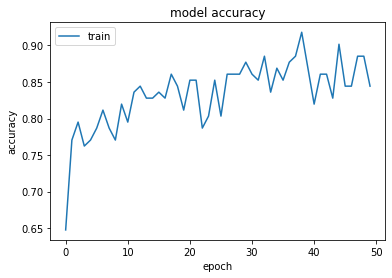

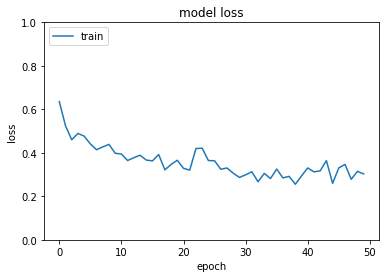

In [136]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
axes = plt.gca()
axes.set_ylim([0,1])
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model2= Sequential()
model2.add(LSTM(100, input_shape=(n_timesteps,n_features)))
model2.add(Dropout(0.5))
model2.add(Dense(100, activation='relu'))
model2.add(Dense(n_outputs, activation='sigmoid'))
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])